In [1]:
import pyspark as ps
from collections import Counter
import pandas as pd
import time
import matplotlib.pyplot as plt
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i 

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [4]:
def casting_function(row):
    if row[0] == 'marketplace':
        return ()
    if len(row)!=15:
        return(len(row))
    (marketplace, customer_id, review_id, product_id, product_parent, product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date) = row
    
    
    return (marketplace, str(customer_id), str(review_id), str(product_id), product_parent, unicode(product_title).encode('utf8'),unicode(product_category).encode('utf8'),int(star_rating),int(helpful_votes),int(total_votes),vine,verified_purchase,unicode(review_headline).encode('utf8'),unicode(review_body).encode('utf8'),review_date)




In [5]:
def time_cast(row):
    pattern = '%Y-%m-%d'
    row =list(row)
    row[14] = int(time.mktime(time.strptime(row[14], pattern)))/86400
    return tuple(row)

In [6]:
def toCSVLine(data):
  return ','.join(str(d) for d in data)

In [7]:
rdd_books = (sc.textFile('s3://amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz')
            .map(lambda rowstr : rowstr.split("\t"))
            .map(casting_function)
           )

In [8]:
rdd_books =rdd_books.filter(lambda x: len(x)==15).map(time_cast)

In [9]:
rdd_sample = rdd_books.filter(lambda x: x[14]%50==0)

star_counts = rdd_books.map(lambda x: Counter({x[cols['star_rating']]:1})).reduce(lambda x, y: x+y)

rdd_sample.count()

In [10]:
pd.DataFrame(rdd_sample.take(10))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,US,38487002,R3LZ2GKGS9YSN4,0198228635,764842125,Brigands with a Cause: Brigandage and Irredent...,Books,5,2,2,N,Y,BRIGANDS WITH A CAUSE :BRIGANDAGE AND IRREDENT...,THE AUTHOR HAS DONE A WONDERFUL JOB IN RESEARC...,13050
1,US,52219048,R1214RCFCW1QLH,080211797X,728208781,Silent Snow: The Slow Poisoning of the Arctic,Books,5,19,20,N,N,More compelling evidence that we continue to w...,In the tradition of Rachel Carson's landmark 1...,13050
2,US,27557367,R1S26QN21ILKA9,141205124X,765322347,Maynard the Mannerly Monkey,Books,5,0,0,N,N,Maynard the sweetest little monkey,Ms. Murphy has created such a lovely character...,13050
3,US,12869335,R2O4W7IVMWCFOE,0975925539,871866639,The Secret Magdalene,Books,5,242,244,N,N,The Book I've Been Waiting For Since I was Nin...,As a feminist and a scholar and a lapsed Catho...,13050
4,US,16445565,R19D87JIUSTEKI,0142001104,662530901,The Art of Possibility: Transforming Professio...,Books,5,3,4,N,N,Best self-help book I've ever read,I've read many books in the self-help/psycholo...,13050
5,US,27643952,R10FXLE3RMQ39D,0375756671,910147112,Standing at the Scratch Line: A Novel (Striver...,Books,5,0,0,N,N,a movie must,This is an excellent book. Probably one of the...,13050
6,US,52983589,RJJ0R2WD23ADE,0465031269,416185932,Why Is Sex Fun?: The Evolution of Human Sexual...,Books,4,5,19,N,N,never too old,"As a \\""senior citizen\\"", you would think I ...",13050
7,US,26569183,R2Y9KCEII5VH4M,0974786918,850234850,"Jeanne Carley's Ferret Calendar 2006, Ferret B...",Books,5,0,0,N,N,Best photographer at capturing ferret's true p...,"Jeanne's work is always top notch, and totally...",13050
8,US,26085645,RZN0CL3NHX2OC,078683384X,368749910,Stanley: The Great Big Book of Everything,Books,4,2,2,N,N,It Really Is The Great Big Book Of Everything!,"My kids, ages 8 and 3, both love this book! T...",13050
9,US,49955228,R2342F3MMUV5Z8,1400040590,110502372,13 Ways of Looking at the Novel,Books,5,105,118,N,N,A Course in Mindful Escape,Today I had the privilege of hearing an author...,13050


In [11]:
#star_counts = rdd_sample.map(lambda x: Counter({x[cols['star_rating']]:1})).reduce(lambda x, y: x+y)

In [12]:
#rdd_sample.saveAsTextFile('file:///home/ec2-user/Amazon_Books/data/sample_02.tsv')

In [13]:
temp = pd.DataFrame(rdd_sample.collect())

sum(['x8b'in x for x in temp[14]])

temp.to_csv('cows.csv')

a = u'\xa1'
unicode(a, "utf-8")

a.decode('utf-8', 'ignore')

In [14]:
unicode('cows').encode('utf8')

'cows'

In [15]:
temp.to_csv('test.csv',index=False)

In [16]:
new_sample = pd.read_csv('test.csv')

In [17]:
helpful_percentage = []
for pos, total in zip(new_sample['8'],new_sample['9']):
    if total>0:
        helpful_percentage.append(float(pos)/float(total))
    else:
        helpful_percentage.append(0)

In [18]:
new_sample['15'] = helpful_percentage

In [19]:
help_df = new_sample[new_sample['8']>0]

In [20]:
help_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,38487002,R3LZ2GKGS9YSN4,0198228635,764842125,Brigands with a Cause: Brigandage and Irredent...,Books,5,2,2,N,Y,BRIGANDS WITH A CAUSE :BRIGANDAGE AND IRREDENT...,THE AUTHOR HAS DONE A WONDERFUL JOB IN RESEARC...,13050,1.000000
1,US,52219048,R1214RCFCW1QLH,080211797X,728208781,Silent Snow: The Slow Poisoning of the Arctic,Books,5,19,20,N,N,More compelling evidence that we continue to w...,In the tradition of Rachel Carson's landmark 1...,13050,0.950000
3,US,12869335,R2O4W7IVMWCFOE,0975925539,871866639,The Secret Magdalene,Books,5,242,244,N,N,The Book I've Been Waiting For Since I was Nin...,As a feminist and a scholar and a lapsed Catho...,13050,0.991803
4,US,16445565,R19D87JIUSTEKI,0142001104,662530901,The Art of Possibility: Transforming Professio...,Books,5,3,4,N,N,Best self-help book I've ever read,I've read many books in the self-help/psycholo...,13050,0.750000
6,US,52983589,RJJ0R2WD23ADE,0465031269,416185932,Why Is Sex Fun?: The Evolution of Human Sexual...,Books,4,5,19,N,N,never too old,"As a \\""senior citizen\\"", you would think I ...",13050,0.263158
8,US,26085645,RZN0CL3NHX2OC,078683384X,368749910,Stanley: The Great Big Book of Everything,Books,4,2,2,N,N,It Really Is The Great Big Book Of Everything!,"My kids, ages 8 and 3, both love this book! T...",13050,1.000000
9,US,49955228,R2342F3MMUV5Z8,1400040590,110502372,13 Ways of Looking at the Novel,Books,5,105,118,N,N,A Course in Mindful Escape,Today I had the privilege of hearing an author...,13050,0.889831
10,US,12532402,R1INTE72S6GPUX,0837603870,959105968,Volkswagen Corrado Official Factory Repair Man...,Books,5,1,1,N,N,Perfect for evryone with a Corrado,"I bought it, cause i am doing a G60 to VR6 con...",13050,1.000000
11,US,21961755,R2WNUJ2DB1ZCCY,0131505483,302554379,Understanding Music (4th Edition),Books,3,2,5,N,N,Understanding Music Text book,I think the book should have questions at the ...,13050,0.400000
12,US,17760743,R2R8FTZED5UP8L,0802411428,574892244,His Word in My Heart: Memorizing Scripture for...,Books,5,24,26,N,N,His Word In My Heart:: Memorizing Scripture fo...,This is one of the best books I've ever read a...,13050,0.923077


(array([  392.,  1221.,  1375.,  2404.,  4544.,  2217.,  4126.,  5758.,
         6118., 25106.]),
 array([0.00485437, 0.10436893, 0.2038835 , 0.30339806, 0.40291262,
        0.50242718, 0.60194175, 0.70145631, 0.80097087, 0.90048544,
        1.        ]),
 <a list of 10 Patch objects>)

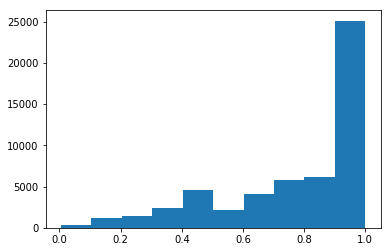

In [21]:
plt.hist(help_df['15'])

In [22]:
#help_df = help_df.sample(frac=.5, random_state=1)

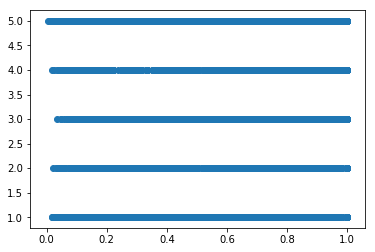

In [23]:
plt.scatter(help_df['15'],help_df['7'])

/home/ec2-user/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([0.03223194, 0.12229176, 0.13651173, 0.28629544, 0.69772665,
        0.30525541, 0.67876668, 1.04216598, 1.20616966, 5.54136524]),
 array([0.00485437, 0.10436893, 0.2038835 , 0.30339806, 0.40291262,
        0.50242718, 0.60194175, 0.70145631, 0.80097087, 0.90048544,
        1.        ]),
 <a list of 10 Patch objects>)

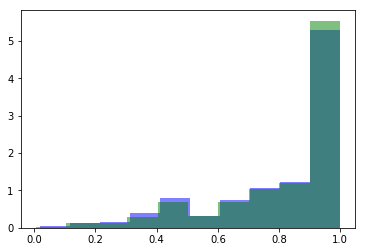

In [24]:
#plt.hist(help_df[help_df['7']==1]['15'],normed=True,alpha=.5,color='red')
#plt.hist(help_df[help_df['7']==2]['15'],normed=True,alpha=.5,color='orange')
#plt.hist(help_df[help_df['7']==3]['15'],normed=True,alpha=.5,color='yellow')
plt.hist(help_df[help_df['7']==4]['15'],normed=True,alpha=.5,color='blue')
plt.hist(help_df[help_df['7']==5]['15'],normed=True,alpha=.5,color='green')

In [25]:
sum(help_df['15']<=.8)

22037

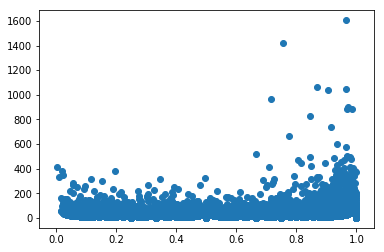

In [26]:
plt.scatter(help_df['15'],help_df['9'])

(0, 200)

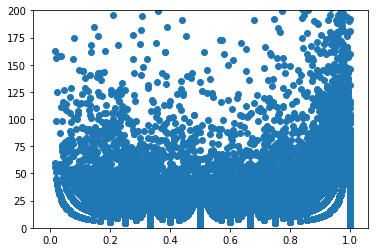

In [27]:
plt.scatter(help_df['15'],help_df['9'])
plt.ylim(0,200)

In [28]:
help_df[help_df['9']>0]['15'].mean()

0.7902008587853685

In [29]:
help_df[help_df['9']>15]['15'].mean()

0.7553008833986103

In [30]:
help_df['9'].median()

7.0

(0, 100)

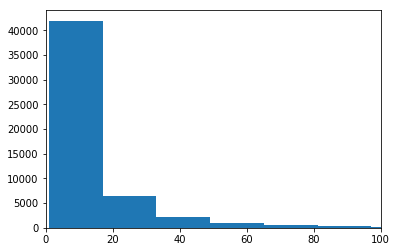

In [31]:
plt.hist(help_df['9'],bins=100)
plt.xlim(0,100)

In [32]:
len(help_df[help_df['9']>3])

38830

In [33]:
sum(help_df['15']>=.66)

40137

In [34]:
sum(help_df['15']<.66)

13124

In [35]:
good_df = help_df[help_df['15']>=.66]
bad_df = help_df[help_df['15']<.66]